In [90]:
!pip install pykrx

In [91]:
from pykrx import stock
from pykrx import bond

import matplotlib.pyplot as plt
import os
import pandas as pd
import numpy as np

from datetime import datetime, timedelta

# 1. target 데이터 확인 및 전처리
- Lag values: 현재 feature값을 가지고 다음날 target을 예측하는 것이기에 하루 차이가 존재함. 그래서 각 날짜에는 현재 feature값과 하루가 지난 target값으로 매핑시켜야 함.

### 1.1 데이터 로드

In [92]:
# ticker 조회
tickers = stock.get_market_ticker_list()
print(tickers)

['095570', '006840', '027410', '282330', '138930', '001460', '001465', '001040', '079160', '00104K', '000120', '011150', '011155', '001045', '097950', '097955', '000590', '012030', '016610', '005830', '000990', '139130', '001530', '000210', '001880', '000215', '375500', '37550L', '37550K', '007340', '004840', '155660', '069730', '017940', '365550', '383220', '007700', '114090', '078930', '006360', '001250', '007070', '078935', '012630', '039570', '089470', '294870', '009540', '267250', '267270', '322000', '042670', '267260', '329180', '097230', '014790', '003580', '204320', '060980', '011200', '082740', '003560', '175330', '234080', '001060', '001067', '001065', '096760', '105560', '432320', '002380', '344820', '009070', '009440', '119650', '092220', '003620', '016380', '001390', '033180', '001940', '025000', '092230', '000040', '044450', '030200', '033780', '058850', '058860', '093050', '003550', '034220', '051900', '051905', '373220', '003555', '032640', '011070', '066570', '066575',

In [93]:
# 특정 ticker에 해당하는 종목명 조회
for ticker in tickers:
    event_name = stock.get_market_ticker_name(ticker)
    if event_name in '삼성전자':
        print(f"ticker: {ticker}, 종목명: {event_name}")

ticker: 005930, 종목명: 삼성전자


In [94]:
# 특정 종목에 대한 1년치 주가 기록 추출
stock_log = stock.get_market_ohlcv("20180711", "20230711", "005930")
len(stock_log)

1234

In [95]:
stock_log.head()

,시가,고가,저가,종가,거래량,거래대금,등락률
날짜,,,,,,,
2018-07-11,46400,46450,45400,46000,11224077,515223640592,-0.65
2018-07-12,45900,46250,45450,45500,11828104,541036686150,-1.09
2018-07-13,45800,46500,45750,46500,11543389,533402245850,2.20
2018-07-16,46800,46800,46000,46050,7678719,356079488741,-0.97
2018-07-17,46150,46200,45600,45850,8892953,408291768123,-0.43


In [96]:
stock_log.shape

(1234, 7)

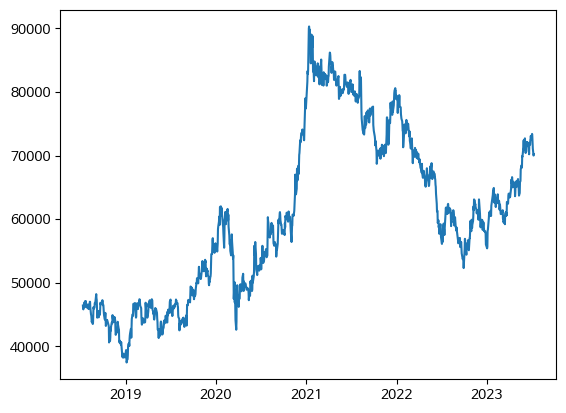

In [97]:
# 시가 그래프 그려보기
plt.plot(stock_log['시가'])

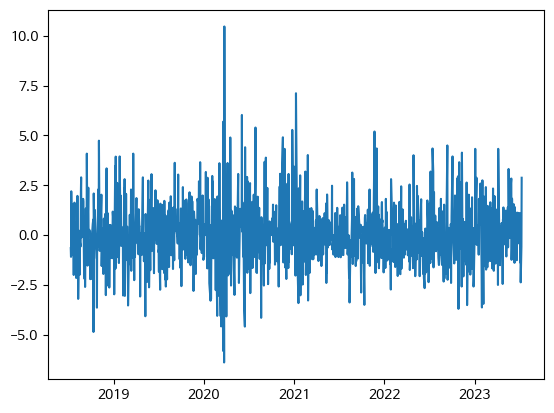

In [98]:
# 등락률 그래프 그려보기
plt.plot(stock_log['등락률'])

In [99]:
# 불러온 데이터 결측치 없음
stock_log.isna().sum()

시가      0
고가      0
저가      0
종가      0
거래량     0
거래대금    0
등락률     0
dtype: int64

### 1.2 주말 제외 누락된 날짜 확인

In [100]:
# 요일 컬럼 생성
stock_log.insert(0, '요일', '')

# 월 ~ 일 -> 0 ~ 6으로 치환
for date in stock_log.index:
    date = datetime.strptime(str(date).split()[0], '%Y-%m-%d')
    day = date.weekday()
    stock_log['요일'][date] = day

stock_log

<ipython-input-100-b30ca27d8780>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  stock_log['요일'][date] = day


,요일,시가,고가,저가,종가,거래량,거래대금,등락률
날짜,,,,,,,,
2018-07-11,2,46400,46450,45400,46000,11224077,515223640592,-0.65
2018-07-12,3,45900,46250,45450,45500,11828104,541036686150,-1.09
2018-07-13,4,45800,46500,45750,46500,11543389,533402245850,2.20
2018-07-16,0,46800,46800,46000,46050,7678719,356079488741,-0.97
2018-07-17,1,46150,46200,45600,45850,8892953,408291768123,-0.43
...,...,...,...,...,...,...,...,...
2023-07-05,2,73000,73300,71900,72000,12310610,889637363400,-1.37
2023-07-06,3,71900,72400,71500,71600,14777667,1061491980700,-0.56
2023-07-07,4,71100,71400,69800,69900,17308877,1215404338500,-2.37


In [101]:
# 토, 일은 집계가 안되어 있음
for i in range(7):
    print(sum(stock_log['요일'] == i))

241
249
244
252
248
0
0


In [102]:
# 평일에 누락된 부분을 확인 => 공휴일(평일)이 누락
full_date_range = pd.date_range(stock_log.index[0], stock_log.index[-1], freq = 'D')  # 전체 날짜 길이 계산
missing_dates = full_date_range.difference(stock_log.index)  # 날짜 중 누락된 날짜 계산

day_num = [0, 1, 2, 3, 4, 5, 6]  # 0 ~ 6(월 ~ 금)
days = [day_num[date.weekday()] for date in missing_dates]  # 누락된 날짜를 숫자로 된 요일로 바꿈

weekday = []  # 누락된 평일을 날짜를 담을 리스트
for date, day in zip(missing_dates, days):
    if day in [0, 1, 2, 3, 4]:  # 월 ~ 금요일에 해당하는 요일
        # print(day)
        weekday.append(date)
    else:  # 주말에 해당하는 요일
        continue

weekday

[Timestamp('2018-08-15 00:00:00'),
 Timestamp('2018-09-24 00:00:00'),
 Timestamp('2018-09-25 00:00:00'),
 Timestamp('2018-09-26 00:00:00'),
 Timestamp('2018-10-03 00:00:00'),
 Timestamp('2018-10-09 00:00:00'),
 Timestamp('2018-12-25 00:00:00'),
 Timestamp('2018-12-31 00:00:00'),
 Timestamp('2019-01-01 00:00:00'),
 Timestamp('2019-02-04 00:00:00'),
 Timestamp('2019-02-05 00:00:00'),
 Timestamp('2019-02-06 00:00:00'),
 Timestamp('2019-03-01 00:00:00'),
 Timestamp('2019-05-01 00:00:00'),
 Timestamp('2019-05-06 00:00:00'),
 Timestamp('2019-06-06 00:00:00'),
 Timestamp('2019-08-15 00:00:00'),
 Timestamp('2019-09-12 00:00:00'),
 Timestamp('2019-09-13 00:00:00'),
 Timestamp('2019-10-03 00:00:00'),
 Timestamp('2019-10-09 00:00:00'),
 Timestamp('2019-12-25 00:00:00'),
 Timestamp('2019-12-31 00:00:00'),
 Timestamp('2020-01-01 00:00:00'),
 Timestamp('2020-01-24 00:00:00'),
 Timestamp('2020-01-27 00:00:00'),
 Timestamp('2020-04-15 00:00:00'),
 Timestamp('2020-04-30 00:00:00'),
 Timestamp('2020-05-

### 1.3 결측치 처리 - 누락된 날짜 포함

In [103]:
# 누락된 날짜(평일) 데이터프레임 생성
weekday_df = pd.DataFrame({'날짜': [day for day in weekday],
                           '요일': [datetime.strptime(str(day).split()[0], '%Y-%m-%d').weekday() for day in weekday],
                           '시가': np.nan,
                           '고가': np.nan,
                           '저가': np.nan,
                           '종가': np.nan,
                           '거래량': np.nan,
                           '거래대금': np.nan,
                           '등락률': np.nan})
weekday_df.set_index('날짜', inplace = True)
weekday_df

,요일,시가,고가,저가,종가,거래량,거래대금,등락률
날짜,,,,,,,,
2018-08-15,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-09-24,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-09-25,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-09-26,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-10-03,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...
2023-03-01,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2023-05-01,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2023-05-05,4,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [104]:
# 누락된 날짜에 대한 데이터프레임 기존 stock_log에 추가
stock_log = stock_log.append(weekday_df).sort_index()
stock_log  # 1234 + 71 = 1305

<ipython-input-104-841324e5d1bf>:2: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  stock_log = stock_log.append(weekday_df).sort_index()


,요일,시가,고가,저가,종가,거래량,거래대금,등락률
날짜,,,,,,,,
2018-07-11,2,46400.0,46450.0,45400.0,46000.0,11224077.0,5.152236e+11,-0.65
2018-07-12,3,45900.0,46250.0,45450.0,45500.0,11828104.0,5.410367e+11,-1.09
2018-07-13,4,45800.0,46500.0,45750.0,46500.0,11543389.0,5.334022e+11,2.20
2018-07-16,0,46800.0,46800.0,46000.0,46050.0,7678719.0,3.560795e+11,-0.97
2018-07-17,1,46150.0,46200.0,45600.0,45850.0,8892953.0,4.082918e+11,-0.43
...,...,...,...,...,...,...,...,...
2023-07-05,2,73000.0,73300.0,71900.0,72000.0,12310610.0,8.896374e+11,-1.37
2023-07-06,3,71900.0,72400.0,71500.0,71600.0,14777667.0,1.061492e+12,-0.56
2023-07-07,4,71100.0,71400.0,69800.0,69900.0,17308877.0,1.215404e+12,-2.37


In [105]:
# 누락된 평일을 추가하여 평일의 수가 균등함
for i in range(7):
    print(sum(stock_log['요일'] == i))

261
261
261
261
261
0
0


In [106]:
# 디버깅 - 결측치 처리 전
stock_log.loc['2018-08-14'], stock_log.loc['2018-08-15']  # (이전날, 결측치)

(요일                   1
 시가             44850.0
 고가             45400.0
 저가             44850.0
 종가             45150.0
 거래량          6409259.0
 거래대금    289642674700.0
 등락률               0.22
 Name: 2018-08-14 00:00:00, dtype: object,
 요일        2
 시가      NaN
 고가      NaN
 저가      NaN
 종가      NaN
 거래량     NaN
 거래대금    NaN
 등락률     NaN
 Name: 2018-08-15 00:00:00, dtype: object)

In [107]:
# 디버깅 - 결측치 처리 전
stock_log.loc['2023-06-05'], stock_log.loc['2023-06-06']  # (이전날, 결측치)

(요일                   0
 시가             72700.0
 고가             72700.0
 저가             71400.0
 종가             71700.0
 거래량         12686829.0
 거래대금    911317330400.0
 등락률              -0.69
 Name: 2023-06-05 00:00:00, dtype: object,
 요일        1
 시가      NaN
 고가      NaN
 저가      NaN
 종가      NaN
 거래량     NaN
 거래대금    NaN
 등락률     NaN
 Name: 2023-06-06 00:00:00, dtype: object)

In [108]:
# 결측치 처리 -> 시가, 고가, 저가, 종가, 거래량, 거래대금, 등락률
for date in stock_log.index:
    columns = ['시가', '고가', '저가', '종가', '거래량', '거래대금', '등락률']
    for column in columns:
        if pd.isna(stock_log[column][date]) == True:
            current_day = stock_log['요일'][date]              # 현재 요일 계산
            previous_day = (stock_log['요일'][date] - 1) % 5   # 이전 요일 계산(예시: 0 -> 4, 1 -> 0, ..., 4 -> 3)
            interval = abs(current_day - previous_day)         # 현재 요일과 이전 요일 간격 계산

            if interval == 4:  # 월요일인 경우
                previous_date = date - pd.Timedelta(days = interval - 1)
                previous_date = str(previous_date).split()[0]
                stock_log[column][date] = stock_log[column][previous_date]

            elif interval == 1:  # 화, 수, 목, 금요일인 경우
                previous_date = date - pd.Timedelta(days = interval)
                previous_date = str(previous_date).split()[0]
                stock_log[column][date] = stock_log[column][previous_date]

<ipython-input-108-59bcd370b173>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  stock_log[column][date] = stock_log[column][previous_date]
<ipython-input-108-59bcd370b173>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  stock_log[column][date] = stock_log[column][previous_date]


In [109]:
# 디버깅 - 결측치 처리 후
stock_log.loc['2018-08-14'], stock_log.loc['2018-08-15']  # (이전날, 결측치)

(요일                   1
 시가             44850.0
 고가             45400.0
 저가             44850.0
 종가             45150.0
 거래량          6409259.0
 거래대금    289642674700.0
 등락률               0.22
 Name: 2018-08-14 00:00:00, dtype: object,
 요일                   2
 시가             44850.0
 고가             45400.0
 저가             44850.0
 종가             45150.0
 거래량          6409259.0
 거래대금    289642674700.0
 등락률               0.22
 Name: 2018-08-15 00:00:00, dtype: object)

In [110]:
# 디버깅 - 결측치 처리 후
stock_log.loc['2023-06-05'], stock_log.loc['2023-06-06']  # (이전날, 결측치)

(요일                   0
 시가             72700.0
 고가             72700.0
 저가             71400.0
 종가             71700.0
 거래량         12686829.0
 거래대금    911317330400.0
 등락률              -0.69
 Name: 2023-06-05 00:00:00, dtype: object,
 요일                   1
 시가             72700.0
 고가             72700.0
 저가             71400.0
 종가             71700.0
 거래량         12686829.0
 거래대금    911317330400.0
 등락률              -0.69
 Name: 2023-06-06 00:00:00, dtype: object)

In [111]:
stock_log.isna().sum()

요일      0
시가      0
고가      0
저가      0
종가      0
거래량     0
거래대금    0
등락률     0
dtype: int64

# 2. feature 데이터 확인 및 전처리

### 2.1 데이터 로드

In [133]:
# 데이터 로드
gold = pd.read_csv('/content/drive/MyDrive/Playdata_Python/project/stock_prediction_project/final_project/data/commodity_brent_crude_5years.csv').sort_index(ascending = False)
# silver = pd.read_csv('/content/drive/MyDrive/Playdata_Python/project/stock_prediction_project/final_project/data/commodity_silver_5years.csv')
# copper = pd.read_csv('/content/drive/MyDrive/Playdata_Python/project/stock_prediction_project/final_project/data/commodity_copper_5years.csv')
# brent = pd.read_csv('/content/drive/MyDrive/Playdata_Python/project/stock_prediction_project/final_project/data/commodity_brent_crude_5years.csv')
# wti = pd.read_csv('/content/drive/MyDrive/Playdata_Python/project/stock_prediction_project/final_project/data/commodity_wti_crude_5years.csv')

gold.shape

(1292, 7)

In [134]:
gold.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1292 entries, 1291 to 0
Data columns (total 7 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   날짜      1292 non-null   object 
 1   종가      1292 non-null   float64
 2   시가      1292 non-null   float64
 3   고가      1292 non-null   float64
 4   저가      1292 non-null   float64
 5   거래량     1290 non-null   object 
 6   변동 %    1292 non-null   object 
dtypes: float64(4), object(3)
memory usage: 80.8+ KB


In [135]:
gold.head()

,날짜,종가,시가,고가,저가,거래량,변동 %
1291,2018- 07- 11,73.40,78.78,78.83,73.04,560.84K,-6.92%
1290,2018- 07- 12,74.45,74.17,75.10,72.67,416.41K,1.43%
1289,2018- 07- 13,75.33,74.34,75.93,73.22,302.43K,1.18%
1288,2018- 07- 16,71.84,74.92,75.37,71.52,330.00K,-4.63%
1287,2018- 07- 17,72.16,72.01,72.78,71.35,286.44K,0.45%


In [136]:
gold.isna().sum()

날짜      0
종가      0
시가      0
고가      0
저가      0
거래량     2
변동 %    0
dtype: int64

### 2.2 기본적인 전처리

##### 2.2.1 날짜 타입 변경 및 index로 설정

In [137]:
# 날짜 type 변경 => datetime64
gold['날짜'] = pd.to_datetime(gold['날짜'])

# 날짜를 index로 설정
gold.set_index('날짜', inplace = True)
gold.head()

,종가,시가,고가,저가,거래량,변동 %
날짜,,,,,,
2018-07-11,73.40,78.78,78.83,73.04,560.84K,-6.92%
2018-07-12,74.45,74.17,75.10,72.67,416.41K,1.43%
2018-07-13,75.33,74.34,75.93,73.22,302.43K,1.18%
2018-07-16,71.84,74.92,75.37,71.52,330.00K,-4.63%
2018-07-17,72.16,72.01,72.78,71.35,286.44K,0.45%


In [138]:
gold.index

DatetimeIndex(['2018-07-11', '2018-07-12', '2018-07-13', '2018-07-16',
               '2018-07-17', '2018-07-18', '2018-07-19', '2018-07-20',
               '2018-07-23', '2018-07-24',
               ...
               '2023-06-28', '2023-06-29', '2023-06-30', '2023-07-03',
               '2023-07-04', '2023-07-05', '2023-07-06', '2023-07-07',
               '2023-07-10', '2023-07-11'],
              dtype='datetime64[ns]', name='날짜', length=1292, freq=None)

###### 2.2.2 거래량 전처리

In [139]:
# 전처리 전
gold['거래량'].tail()

날짜
2023-07-05    293.74K
2023-07-06      0.43K
2023-07-07    331.53K
2023-07-10    288.40K
2023-07-11        NaN
Name: 거래량, dtype: object

In [140]:
# 거래량 숫자로 치환
for i in range(len(gold['거래량'])):
    if pd.isna(gold['거래량'][i]) == True:            # 결측치 제외 => 나중에 feature과 target합치고 나서 결측치 처리할 예정
        continue
    else:
        remove_k = gold['거래량'][i].replace('K', '')  # 'K 제거
        str_2_float = float(remove_k)                  # type 변경: str -> float
        multiply_thousand = int(str_2_float * 1000)    # 1000(K) 곱하고 type을 int로 치환
        gold['거래량'][i] = multiply_thousand

gold['거래량'].tail()  # 전처리 후

<ipython-input-140-32f0e91e9b6e>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  gold['거래량'][i] = multiply_thousand


날짜
2023-07-05    293740
2023-07-06       430
2023-07-07    331530
2023-07-10    288400
2023-07-11       NaN
Name: 거래량, dtype: object

##### 2.2.3 변동 전처리

In [141]:
# 전처리 전
gold['변동 %'].head()

날짜
2018-07-11    -6.92%
2018-07-12     1.43%
2018-07-13     1.18%
2018-07-16    -4.63%
2018-07-17     0.45%
Name: 변동 %, dtype: object

In [142]:
# 변동에 % 제거
for i in range(len(gold['변동 %'])):
    gold['변동 %'][i] = float(gold['변동 %'][i].replace('%', '').strip())

# 컬럼명 변경
gold.rename(columns = {'변동 %': '변동'}, inplace = True)

gold['변동'].head()  # 전처리 후

<ipython-input-142-c5873ccab5f4>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  gold['변동 %'][i] = float(gold['변동 %'][i].replace('%', '').strip())


날짜
2018-07-11   -6.92
2018-07-12    1.43
2018-07-13    1.18
2018-07-16   -4.63
2018-07-17    0.45
Name: 변동, dtype: object

### 2.3 주말 제외 누락된 날짜 확인

In [143]:
# 요일 컬럼 생성
gold.insert(0, '요일', '')

# 월 ~ 일 -> 0 ~ 6으로 치환
for date in gold.index:
    date = datetime.strptime(str(date).split()[0], '%Y-%m-%d')
    day = date.weekday()
    gold['요일'][date] = day

gold

<ipython-input-143-d1edcf97b631>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  gold['요일'][date] = day


,요일,종가,시가,고가,저가,거래량,변동
날짜,,,,,,,
2018-07-11,2,73.40,78.78,78.83,73.04,560840,-6.92
2018-07-12,3,74.45,74.17,75.10,72.67,416410,1.43
2018-07-13,4,75.33,74.34,75.93,73.22,302430,1.18
2018-07-16,0,71.84,74.92,75.37,71.52,330000,-4.63
2018-07-17,1,72.16,72.01,72.78,71.35,286440,0.45
...,...,...,...,...,...,...,...
2023-07-05,2,76.65,76.03,76.95,75.30,293740,0.52
2023-07-06,3,76.52,76.70,77.09,75.03,430,-0.17
2023-07-07,4,78.47,76.52,78.54,76.03,331530,2.55


In [144]:
# 토, 일은 집계가 안되어 있음
for i in range(7):
    print(sum(gold['요일'] == i))

259
259
259
261
254
0
0


In [145]:
# 평일에 누락된 부분을 확인 => 공휴일(평일)이 누락
full_date_range = pd.date_range(gold.index[0], gold.index[-1], freq = 'D')  # 전체 날짜 길이 계산
missing_dates = full_date_range.difference(gold.index)  # 날짜 중 누락된 날짜 계산

day_num = [0, 1, 2, 3, 4, 5, 6]  # 0 ~ 6(월 ~ 금)
days = [day_num[date.weekday()] for date in missing_dates]  # 누락된 날짜를 숫자로 된 요일로 바꿈

weekday = []  # 누락된 평일을 날짜를 담을 리스트
for date, day in zip(missing_dates, days):
    if day in [0, 1, 2, 3, 4]:  # 월 ~ 금요일에 해당하는 요일
        # print(day)
        weekday.append(date)
    else:  # 주말에 해당하는 요일
        continue

weekday

[Timestamp('2018-12-25 00:00:00'),
 Timestamp('2019-01-01 00:00:00'),
 Timestamp('2019-04-19 00:00:00'),
 Timestamp('2019-12-25 00:00:00'),
 Timestamp('2020-01-01 00:00:00'),
 Timestamp('2020-04-10 00:00:00'),
 Timestamp('2020-12-25 00:00:00'),
 Timestamp('2021-01-01 00:00:00'),
 Timestamp('2021-04-02 00:00:00'),
 Timestamp('2022-04-15 00:00:00'),
 Timestamp('2022-12-26 00:00:00'),
 Timestamp('2023-01-02 00:00:00'),
 Timestamp('2023-04-07 00:00:00')]

### 2.4 결측치 처리 - 누락된 날짜 포함

In [146]:
# 누락된 날짜(평일) 데이터프레임 생성
weekday_df = pd.DataFrame({'날짜': [day for day in weekday],
                           '요일': [datetime.strptime(str(day).split()[0], '%Y-%m-%d').weekday() for day in weekday],
                           '시가': np.nan,
                           '고가': np.nan,
                           '저가': np.nan,
                           '거래량': np.nan,
                           '변동': np.nan})
weekday_df.set_index('날짜', inplace = True)
weekday_df

,요일,시가,고가,저가,거래량,변동
날짜,,,,,,
2018-12-25,1,NaN,NaN,NaN,NaN,NaN
2019-01-01,1,NaN,NaN,NaN,NaN,NaN
2019-04-19,4,NaN,NaN,NaN,NaN,NaN
2019-12-25,2,NaN,NaN,NaN,NaN,NaN
2020-01-01,2,NaN,NaN,NaN,NaN,NaN
2020-04-10,4,NaN,NaN,NaN,NaN,NaN
2020-12-25,4,NaN,NaN,NaN,NaN,NaN
2021-01-01,4,NaN,NaN,NaN,NaN,NaN
2021-04-02,4,NaN,NaN,NaN,NaN,NaN


In [147]:
# 누락된 날짜에 대한 데이터프레임 기존 gold에 추가
gold = gold.append(weekday_df).sort_index()
gold  # 1292 + 13 = 1305

<ipython-input-147-188d71264900>:2: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  gold = gold.append(weekday_df).sort_index()


,요일,종가,시가,고가,저가,거래량,변동
날짜,,,,,,,
2018-07-11,2,73.40,78.78,78.83,73.04,560840,-6.92
2018-07-12,3,74.45,74.17,75.10,72.67,416410,1.43
2018-07-13,4,75.33,74.34,75.93,73.22,302430,1.18
2018-07-16,0,71.84,74.92,75.37,71.52,330000,-4.63
2018-07-17,1,72.16,72.01,72.78,71.35,286440,0.45
...,...,...,...,...,...,...,...
2023-07-05,2,76.65,76.03,76.95,75.30,293740,0.52
2023-07-06,3,76.52,76.70,77.09,75.03,430,-0.17
2023-07-07,4,78.47,76.52,78.54,76.03,331530,2.55


In [148]:
# 누락된 평일을 추가하여 평일의 수가 균등함
for i in range(7):
    print(sum(gold['요일'] == i))

261
261
261
261
261
0
0


In [149]:
# 디버깅 - 결측치 처리 전
gold.loc['2023-04-06'], gold.loc['2023-04-07']  # (이전날, 결측치)

(요일          3
 종가      85.12
 시가      84.89
 고가      85.45
 저가      84.05
 거래량    259620
 변동       0.15
 Name: 2023-04-06 00:00:00, dtype: object,
 요일       4
 종가     NaN
 시가     NaN
 고가     NaN
 저가     NaN
 거래량    NaN
 변동     NaN
 Name: 2023-04-07 00:00:00, dtype: object)

In [150]:
# 디버깅 - 결측치 처리 전
gold.loc['2018-12-24'], gold.loc['2018-12-25']  # (이전날, 결측치)

(요일         0
 종가     50.47
 시가     53.49
 고가     54.66
 저가     50.36
 거래량    76220
 변동     -6.22
 Name: 2018-12-24 00:00:00, dtype: object,
 요일       1
 종가     NaN
 시가     NaN
 고가     NaN
 저가     NaN
 거래량    NaN
 변동     NaN
 Name: 2018-12-25 00:00:00, dtype: object)

In [151]:
# 결측치 처리 -> '종가', '시가', '고가', '저가', '거래량', '변동'
for date in gold.index:
    columns = ['종가', '시가', '고가', '저가', '거래량', '변동']
    for column in columns:
        if pd.isna(gold[column][date]) == True:
            current_day = gold['요일'][date]              # 현재 요일 계산
            previous_day = (gold['요일'][date] - 1) % 5   # 이전 요일 계산(예시: 0 -> 4, 1 -> 0, ..., 4 -> 3)
            interval = abs(current_day - previous_day)    # 현재 요일과 이전 요일 간격 계산

            if interval == 4:  # 월요일인 경우
                previous_date = date - pd.Timedelta(days = interval - 1)
                previous_date = str(previous_date).split()[0]
                gold[column][date] = gold[column][previous_date]

            elif interval == 1:  # 화, 수, 목, 금요일인 경우
                previous_date = date - pd.Timedelta(days = interval)
                previous_date = str(previous_date).split()[0]
                gold[column][date] = gold[column][previous_date]

<ipython-input-151-067962ea68c2>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  gold[column][date] = gold[column][previous_date]
<ipython-input-151-067962ea68c2>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  gold[column][date] = gold[column][previous_date]


In [152]:
# 디버깅 - 결측치 처리 후
gold.loc['2023-04-06'], gold.loc['2023-04-07']  # (이전날, 결측치)

(요일          3
 종가      85.12
 시가      84.89
 고가      85.45
 저가      84.05
 거래량    259620
 변동       0.15
 Name: 2023-04-06 00:00:00, dtype: object,
 요일          4
 종가      85.12
 시가      84.89
 고가      85.45
 저가      84.05
 거래량    259620
 변동       0.15
 Name: 2023-04-07 00:00:00, dtype: object)

In [153]:
# 디버깅 - 결측치 처리 후
gold.loc['2018-12-24'], gold.loc['2018-12-25']  # (이전날, 결측치)

(요일         0
 종가     50.47
 시가     53.49
 고가     54.66
 저가     50.36
 거래량    76220
 변동     -6.22
 Name: 2018-12-24 00:00:00, dtype: object,
 요일         1
 종가     50.47
 시가     53.49
 고가     54.66
 저가     50.36
 거래량    76220
 변동     -6.22
 Name: 2018-12-25 00:00:00, dtype: object)

In [154]:
gold.isna().sum()

요일     0
종가     0
시가     0
고가     0
저가     0
거래량    0
변동     0
dtype: int64

# 3. 사용할 데이터셋 만들기(feature + target)

In [155]:
# target 컬럼명 '시가' -> '주식시가'로 변경
stock_log.rename(columns = {'시가' : '주식시가'}, inplace = True)

# concat_dataset = feature + target
concat_dataset = pd.concat([gold, stock_log['주식시가']], axis = 1)
concat_dataset.head()

,요일,종가,시가,고가,저가,거래량,변동,주식시가
날짜,,,,,,,,
2018-07-11,2,73.40,78.78,78.83,73.04,560840,-6.92,46400.0
2018-07-12,3,74.45,74.17,75.10,72.67,416410,1.43,45900.0
2018-07-13,4,75.33,74.34,75.93,73.22,302430,1.18,45800.0
2018-07-16,0,71.84,74.92,75.37,71.52,330000,-4.63,46800.0
2018-07-17,1,72.16,72.01,72.78,71.35,286440,0.45,46150.0


In [156]:
concat_dataset.shape

(1305, 8)

In [157]:
# 저장
path = '/content/drive/MyDrive/Playdata_Python/project/stock_prediction_project/final_project/data/'
concat_dataset.to_csv(path + 'preprocessed_goldnstock.csv')